In [2]:
!pip install happytransformer 
!pip install gradio
from IPython.display import clear_output
clear_output()
import csv
from datasets import load_dataset
from happytransformer import TTSettings
from happytransformer import TTTrainArgs
from happytransformer import HappyTextToText
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from nltk.stem import PorterStemmer
from nltk import sent_tokenize, word_tokenize
import gradio as gr

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
happy_tt = HappyTextToText("T5", "t5-base")

/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [4]:
train_dataset = load_dataset("jfleg", split='validation[:]')

eval_dataset = load_dataset("jfleg", split='test[:]')

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating validation split:   0%|          | 0/755 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/748 [00:00<?, ? examples/s]

Dataset jfleg downloaded and prepared to /root/.cache/huggingface/datasets/jfleg/default/1.0.0/ed4ab2367351fe31949f48849ae6732b164f0d5ea6bb5d4357ff4293ac89511b. Subsequent calls will reuse this data.


In [5]:
for case in train_dataset["corrections"][:2]:
    print(case)
    print("--------------------------------------------------------")
    print(case[0])
    print("--------------------------------------------------------")

['So I think we would not be alive if our ancestors did not develop sciences and technologies . ', 'So I think we could not live if older people did not develop science and technologies . ', 'So I think we can not live if old people could not find science and technologies and they did not develop . ', 'So I think we can not live if old people can not find the science and technology that has not been developed . ']
--------------------------------------------------------
So I think we would not be alive if our ancestors did not develop sciences and technologies . 
--------------------------------------------------------
['Not for use with a car . ', 'Do not use in the car . ', 'Car not for use . ', 'Can not use the car . ']
--------------------------------------------------------
Not for use with a car . 
--------------------------------------------------------


In [6]:
def generate_csv(csv_path, dataset):
    with open(csv_path, 'w', newline='') as csvfile:
        writter = csv.writer(csvfile)
        writter.writerow(["input", "target"])
        for case in dataset:
            input_text = "grammar: " + case["sentence"]
            for correction in case["corrections"]:
                # a few of the cases contain blank strings. 
                if input_text and correction:
                    writter.writerow([input_text, correction])

In [7]:
generate_csv("train.csv", train_dataset)
generate_csv("eval.csv", eval_dataset)

In [8]:
data = pd.read_csv('train.csv')
data.shape

(3016, 2)

In [9]:
data.head()

,input,target
0,grammar: So I think we can not live if old peo...,So I think we would not be alive if our ancest...
1,grammar: So I think we can not live if old peo...,So I think we could not live if older people d...
2,grammar: So I think we can not live if old peo...,So I think we can not live if old people could...
3,grammar: So I think we can not live if old peo...,So I think we can not live if old people can n...
4,grammar: For not use car .,Not for use with a car .


In [10]:
data['Total Words'] = data['input'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["input"].apply(count_total_words)

In [11]:
data.head()

,input,target,Total Words,Total Chars
0,grammar: So I think we can not live if old peo...,So I think we would not be alive if our ancest...,23,96
1,grammar: So I think we can not live if old peo...,So I think we could not live if older people d...,23,96
2,grammar: So I think we can not live if old peo...,So I think we can not live if old people could...,23,96
3,grammar: So I think we can not live if old peo...,So I think we can not live if old people can n...,23,96
4,grammar: For not use car .,Not for use with a car .,6,21


In [12]:
def convert_lowercase(text):
    text = text.lower()
    return text

data['input'] = data['input'].apply(convert_lowercase)

In [13]:
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['input'] = data['input'].apply(remove_url)

In [14]:
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data['input'] = data['input'].apply(remove_punc)

In [15]:
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['text_clean'] = data['input'].apply(word_tokenize)
data.head()

,input,target,Total Words,Total Chars,text_clean
0,grammar so i think we can not live if old peop...,So I think we would not be alive if our ancest...,23,96,"[grammar, so, i, think, we, can, not, live, if..."
1,grammar so i think we can not live if old peop...,So I think we could not live if older people d...,23,96,"[grammar, so, i, think, we, can, not, live, if..."
2,grammar so i think we can not live if old peop...,So I think we can not live if old people could...,23,96,"[grammar, so, i, think, we, can, not, live, if..."
3,grammar so i think we can not live if old peop...,So I think we can not live if old people can n...,23,96,"[grammar, so, i, think, we, can, not, live, if..."
4,grammar for not use car,Not for use with a car .,6,21,"[grammar, for, not, use, car]"


In [16]:
data['Total Words After Transformation'] = data['input'].apply(lambda x: np.log(len(x.split())))

In [17]:
data.head()

,input,target,Total Words,Total Chars,text_clean,Total Words After Transformation
0,grammar so i think we can not live if old peop...,So I think we would not be alive if our ancest...,23,96,"[grammar, so, i, think, we, can, not, live, if...",3.091042
1,grammar so i think we can not live if old peop...,So I think we could not live if older people d...,23,96,"[grammar, so, i, think, we, can, not, live, if...",3.091042
2,grammar so i think we can not live if old peop...,So I think we can not live if old people could...,23,96,"[grammar, so, i, think, we, can, not, live, if...",3.091042
3,grammar so i think we can not live if old peop...,So I think we can not live if old people can n...,23,96,"[grammar, so, i, think, we, can, not, live, if...",3.091042
4,grammar for not use car,Not for use with a car .,6,21,"[grammar, for, not, use, car]",1.609438


In [18]:
data2 = pd.read_csv('eval.csv')
data2.shape

(2988, 2)

In [19]:
data2.head()

,input,target
0,grammar: New and new technology has been intro...,New technology has been introduced to society .
1,grammar: New and new technology has been intro...,New technology has been introduced into the so...
2,grammar: New and new technology has been intro...,Newer and newer technology has been introduced...
3,grammar: New and new technology has been intro...,Newer and newer technology has been introduced...
4,grammar: One possible outcome is that an envir...,One possible outcome is that an environmentall...


In [20]:
import string
from nltk import word_tokenize
import nltk
from nltk.stem import PorterStemmer
ps = PorterStemmer()

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer()
tfidf_vec_fit = tfidf_vec.fit(data['input'])
X_tfidf = tfidf_vec.fit_transform(data['input'])
print(X_tfidf.shape)
df = pd.DataFrame(X_tfidf.toarray(), columns = tfidf_vec.get_feature_names_out())
df.head()


(3016, 2515)


,0th,1th,2th,4they,75,7unsuspection,ability,able,aboue,about,...,york,you,youg,young,younger,youngsters,your,youth,youths,ypu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/tmp/ipykernel_32/1420194302.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x = data['Total Words'], shade = True)


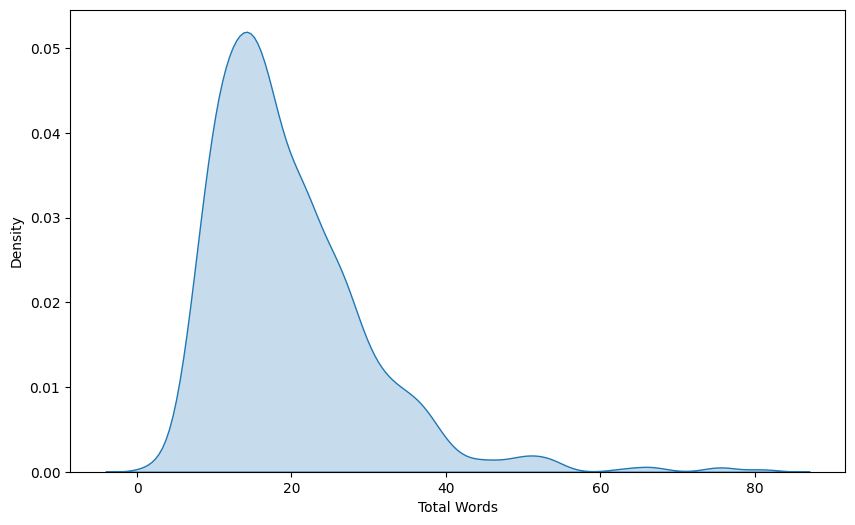

In [21]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], shade = True)
plt.show()

/tmp/ipykernel_32/2195569933.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x = data['Total Chars'], shade = True)


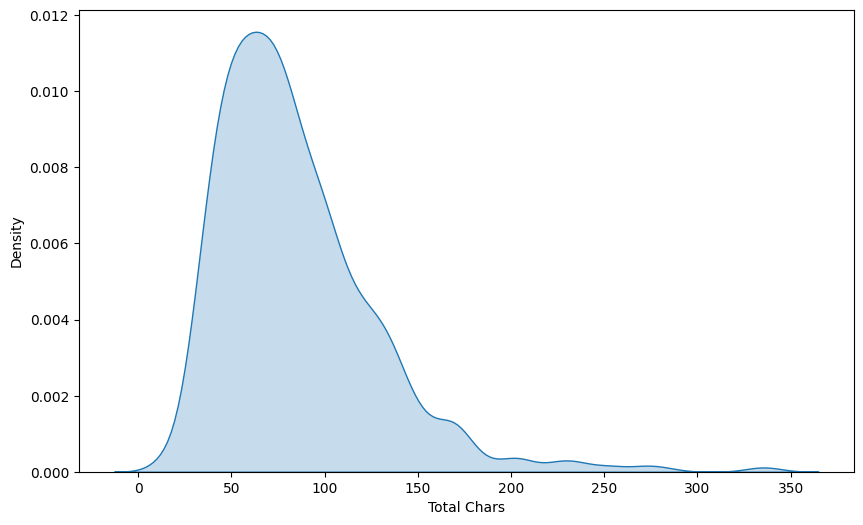

In [22]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Chars'], shade = True)
plt.show()

In [23]:
before_result = happy_tt.eval("eval.csv")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-89db94fc00b016eb/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [24]:
print("Before loss:", before_result.loss)


Before loss: 1.2803919315338135


In [25]:
args = TTTrainArgs(batch_size=8)
happy_tt.train("train.csv", args=args)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-f2aebbe8463ff711/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.548700


In [26]:
before_loss = happy_tt.eval("eval.csv")

print("After loss: ", before_loss.loss)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

After loss:  0.4558851420879364


In [27]:
beam_settings =  TTSettings(num_beams=5, min_length=1, max_length=100)


In [33]:
text = "grammar: I does any every things for yours and yours mothers."
result = happy_tt.generate_text(text, args=beam_settings)
print(result.text)


I do anything for yours and yours mothers.


In [29]:
def correct_Grammer(app_inputs):
    result = happy_tt.generate_text(app_inputs, args=beam_settings)
    return (result.text)

In [30]:
Grammer_correction_if = gr.Interface(fn = correct_Grammer,
                                      inputs="text",
                                      outputs = "text")

In [31]:
Grammer_correction_if.launch()

Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://3e2ccc7cfa4cb44ea6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
